This notebook is a duplicate of the one named `timing-vs-gaiaedr3-position-comparison-with-true-match`, where only non-MSPs were included.

In [1]:
from functools import reduce

import numpy as np
from matplotlib import pyplot as plt

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import seaborn as sns

from statsmodels.iolib.table import SimpleTable
from psrcrf_tools import *

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

## 1.1 Load the database

Read the timing solution data.

In [2]:
timing_table = Table.read("../data/timing_edr3.fits",)
timing_table.sort("psr_name")

Remove one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the *Gaia* EDR3.

In [3]:
mask = (
    (timing_table["psr_name"] != "J1435-6100")
    & (timing_table["psr_name"] != "J1955+2908")
    & (timing_table["psr_name"] != "J1546-5302")
)
timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [4]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [5]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")
edr3_antf_table.sort("name")

Find millisecond pulsars (MSPs) using the classification provided in J. Antoiniadis (2021).

In [6]:
B_over_G = 3.2e19 * np.sqrt(edr3_antf_table["p0"] * edr3_antf_table["p1"])

mask = (B_over_G <= 1e10)
msp_list = edr3_antf_table["name"][mask]

Only keep the astrometric parameters from Gaia.

In [7]:
edr3_antf_table = edr3_antf_table['name', 'source_id', 'ra', 'ra_error', 'dec',
                                  'dec_error', 'parallax', 'parallax_error',
                                  'pmra', 'pmra_error', 'pmdec',
                                  'pmdec_error', ]

edr3_antf_table.rename_columns([
    "name", "ra_error", "dec_error", "parallax", "parallax_error",
    "pmra_error", "pmdec_error"
], [
    "psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"
])

Add unit information

In [8]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Only consider the young pulsars in the data.

In [9]:
for msp_name in msp_list:
    mask = ((timing_table["psr_name"] != msp_name))
    timing_table = Table(timing_table[mask], masked=False)

Supplement the timing table with the Gaia astrometrical information.

In [10]:
edr3_timing = join(timing_table,
                   edr3_antf_table,
                   keys="psr_name",
                   join_type="left",
                   table_names=["t", "g"])

count_psr_nb(edr3_timing)

There are 17 pulsars with 21 measurements.


## 1.2 Comparison of pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [11]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

In [12]:
# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (edr3_timing["ra_t"] - edr3_timing["ra_g"]) * \
    dec_fac - dt_y * edr3_timing["pmra_g"]

ddec = edr3_timing["dec_t"] - edr3_timing[
    "dec_g"] - dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [13]:
edr3_timing["ra_err_t"] = edr3_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(edr3_timing["ra_err_g"]**2
                  + edr3_timing["ra_err_t"]**2
                  + (dt_y*edr3_timing["pmra_err_g"]).value**2)

ddec_err = np.sqrt(edr3_timing["dec_err_g"]**2
                   + edr3_timing["dec_err_t"]**2
                   + (dt_y*edr3_timing["pmdec_err_g"]).value**2)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

## 1.3 Plot the sky distribution

In [14]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

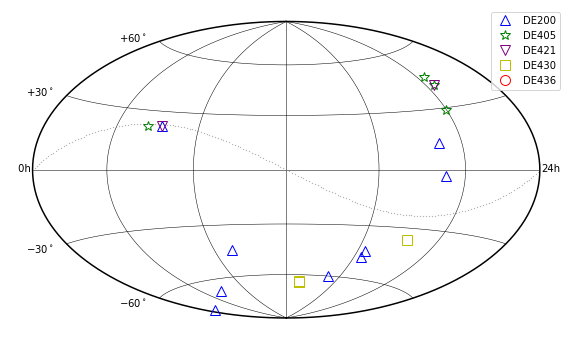

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, '$+%d^\circ$' % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, '$-%d^\circ$' % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(edr3_timing200["ra_g"],
                         edr3_timing200["dec_g"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(edr3_timing405["ra_g"],
                         edr3_timing405["dec_g"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(edr3_timing421["ra_g"],
                         edr3_timing421["dec_g"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(edr3_timing430["ra_g"],
                         edr3_timing430["dec_g"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(edr3_timing436["ra_g"],
                         edr3_timing436["dec_g"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

# Ecliptic plane
lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of position formal uncertainties

In [16]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((4, 6))

pos_err_tab[0, :] = calc_med_pos_err(edr3_timing200)
pos_err_tab[1, :] = calc_med_pos_err(edr3_timing405)
pos_err_tab[2, :] = calc_med_pos_err(edr3_timing421)
pos_err_tab[3, :] = calc_med_pos_err(edr3_timing430)

## 1.5 Remove pulsars near the ecliptic plane

In [17]:
mask = (
    (edr3_timing["psr_name"] != "J0614+2229")
    & (edr3_timing["psr_name"] != "J0534+2200")
    & (edr3_timing["psr_name"] != "J0337+1715")
    & (edr3_timing["psr_name"] != "J2339-0533")
    #     & (edr3_timing["psr_name"] != "J1723-2837")
    #     & (edr3_timing["psr_name"] != "J2129-0429")
    #     & (edr3_timing["psr_name"] != "J1023+0038")
)
edr3_timing = Table(edr3_timing[mask], masked=False)

# 2 Compare timing and Gaia reference frames

##  2.1 DE200 vs Gaia EDR3

In [18]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]


count_psr_nb(edr3_timing200)
# edr3_timing200

There are 8 pulsars with 8 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


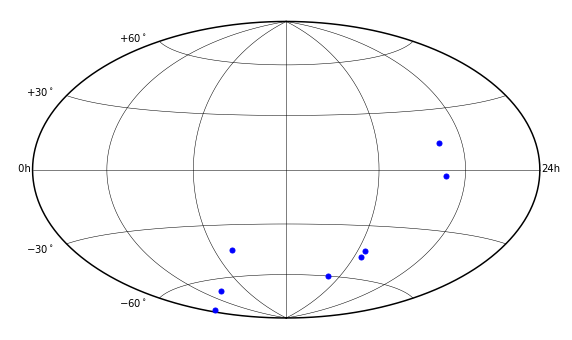

In [19]:
sou_dist_plot(edr3_timing200["ra_g"], edr3_timing200["dec_g"],)
#               "../plots/de200_gedr3_psr.eps")

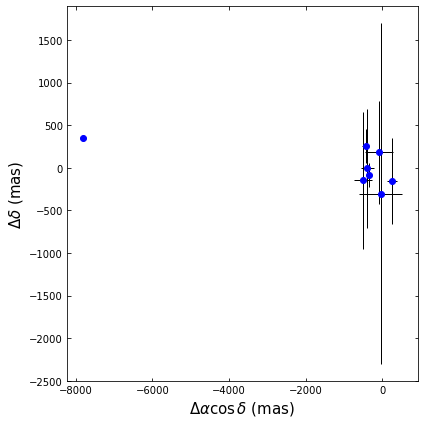

In [20]:
simple_plot(edr3_timing200)

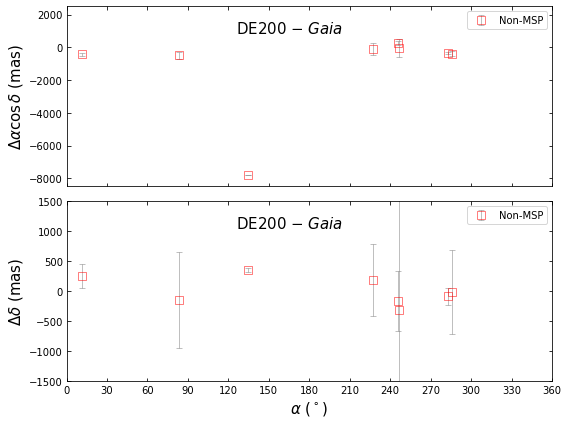

In [21]:
pos_oft_vs_coord(
    edr3_timing200,
    [-8500, 2500, -1500, 1500],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="ra",
    divided=True)

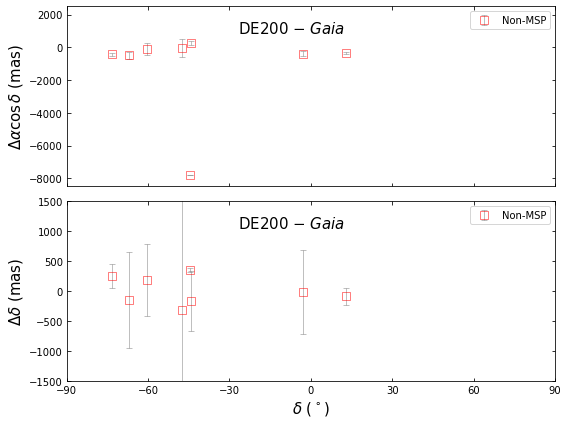

In [22]:
pos_oft_vs_coord(
    edr3_timing200,
    [-8500, 2500, -1500, 1500],
    # Prefit
    edr3_timing200["dra"],
    edr3_timing200["ddec"],
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$"],
    ref="g",
    xaxis="dec",
    divided=True)

In [23]:
mask = ((np.fabs(edr3_timing200["dra"]) < 1000)
        & (np.fabs(edr3_timing200["ddec"]) < 1000)
        )

edr3_timing200 = edr3_timing200[mask]

nb_psr_200 = len(edr3_timing200.group_by("psr_name").groups)
nb_obs_200 = len(edr3_timing200)

count_psr_nb(edr3_timing200)

There are 7 pulsars with 7 measurements.


In [24]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    edr3_timing200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  7      7.2      1.1    -167.32    -383.97    -292.23 J1851+1259    49908      5.4
 2  6      5.0      0.4    -277.07    -402.31    -309.27 J0045-7319    49144      0.2
 3  5      2.3      0.5    -158.36    -477.28    -310.41 J1903-0258    53095      0.5
 4  4      2.1      0.4     -82.92    -422.86    -136.88 J0534-6703    52410      0.1
 5  3      1.8      0.1     414.09     648.02    1079.42 J1624-4411    53058      0.0


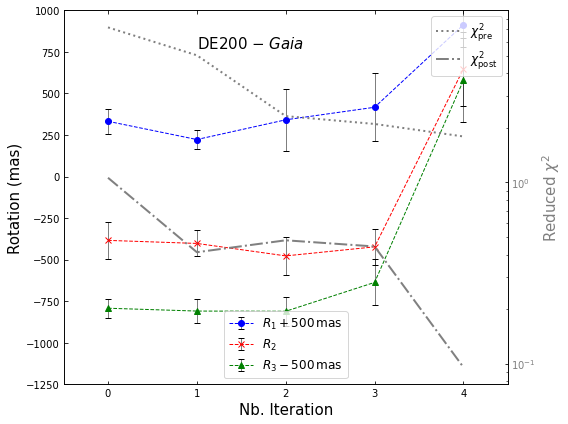

In [25]:
rot_vs_iter(
    pmt200,
    sig200,
    [-0.5, 4.5, -1250, 1000],
    elw=0.5,
    add_text=[0.3, 0.9, "DE200 $-$ $Gaia$"],
    apr_chi2=apr_chi2_200,
    pst_chi2=pst_chi2_200,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=500
)

In [26]:
rot200, iqr200 = find_pmt_est(pmt200)

dra_200, ddec_200 = calc_dpos(edr3_timing200, rot200)

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(edr3_timing200, dra_200, ddec_200)

## 2.2 DE405 vs Gaia EDR3

In [27]:
mask = edr3_timing["eph"] == "DE405"
edr3_timing405 = edr3_timing[mask]

count_psr_nb(edr3_timing405)
# edr3_timing405

There are 3 pulsars with 3 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


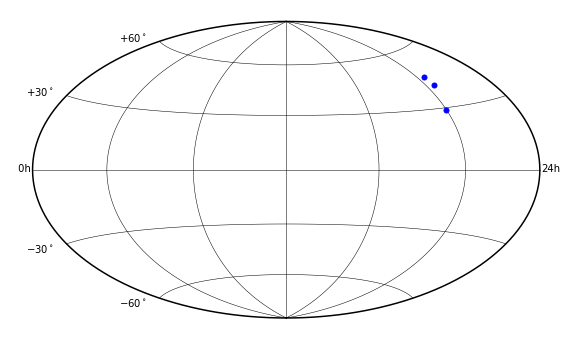

In [28]:
sou_dist_plot(edr3_timing405["ra_g"], edr3_timing405["dec_g"],)

We have 12 pulsars in the sample from DE405 vs. Gaia comparison.

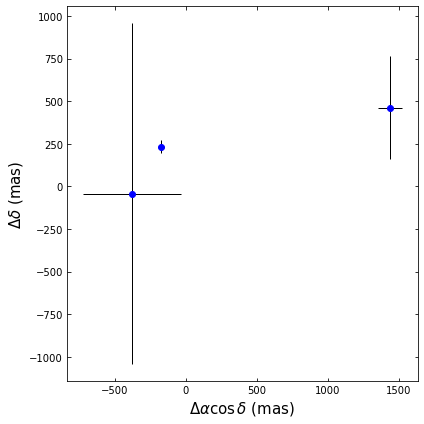

In [29]:
simple_plot(edr3_timing405)

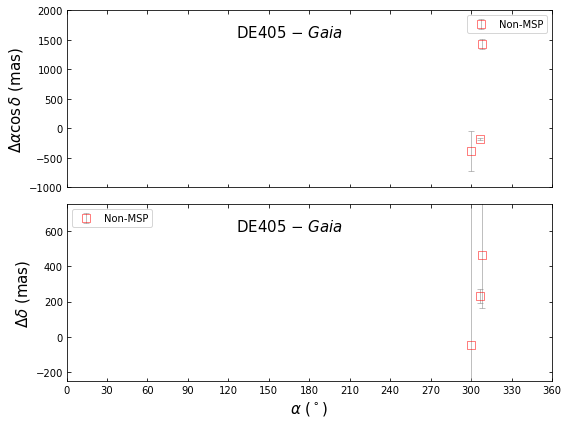

In [30]:
pos_oft_vs_coord(edr3_timing405, [-1000, 2000, -250, 750],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 ref="g",
                 xaxis="ra",
                 add_text=[0.35, 0.85, "DE405 $-$ $Gaia$"],
                 divided=True)

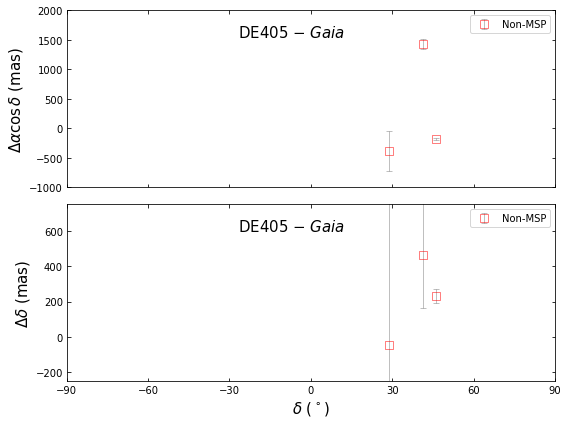

In [31]:
pos_oft_vs_coord(edr3_timing405, [-1000, 2000, -250, 750],
                 edr3_timing405["dra"],
                 edr3_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.35, 0.85, "DE405 $-$ $Gaia$"],
                 divided=True)

In [32]:
rot405, iqr405, dra_405, ddec_405, a_chi2_405, p_chi2_405 = simple_rot_fit_4_table(
    edr3_timing405, ref="g")

[msg] There are 3 timing solutions for 3 pulsars
[msg] Before removing outliers, the reduced chi-squared is 78.80.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  3  3     78.8     88.1    4190.67   -5999.99    7364.79    2594.97    3454.79    4405.18


In [33]:
mask = (
    (np.fabs(edr3_timing405["dra"]) < 1000)
    & (np.fabs(edr3_timing405["ddec"]) < 1000)
)

edr3_timing405 = edr3_timing405[mask]

nb_psr_405 = len(edr3_timing405.group_by("psr_name").groups)
nb_obs_405 = len(edr3_timing405)

count_psr_nb(edr3_timing405)

There are 2 pulsars with 2 measurements.


## 2.3 DE421 vs Gaia EDR3

In [34]:
mask = edr3_timing["eph"] == "DE421"
edr3_timing421 = edr3_timing[mask]

nb_psr_421 = len(edr3_timing421.group_by("psr_name").groups)
nb_obs_421 = len(edr3_timing421)

count_psr_nb(edr3_timing421)

There are 1 pulsars with 1 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


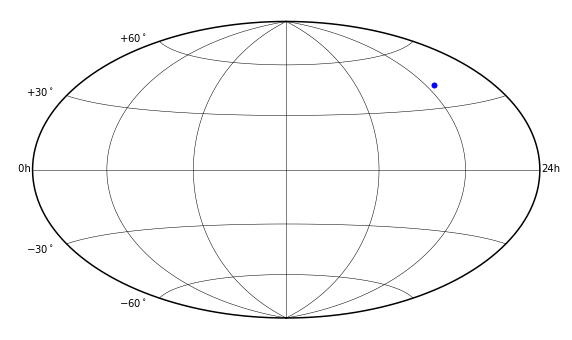

In [35]:
sou_dist_plot(edr3_timing421["ra_g"], edr3_timing421["dec_g"],)
#               "../plots/gedr3_de421_psr.eps")

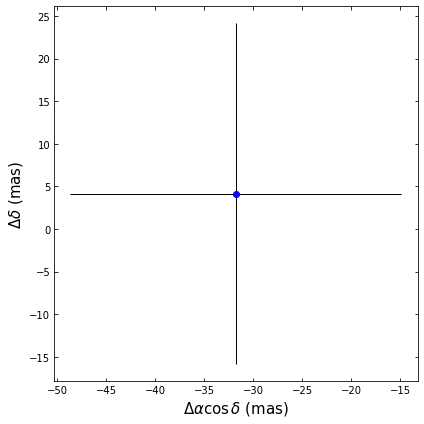

In [36]:
simple_plot(edr3_timing421)

In [37]:
# pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
#     edr3_timing421)

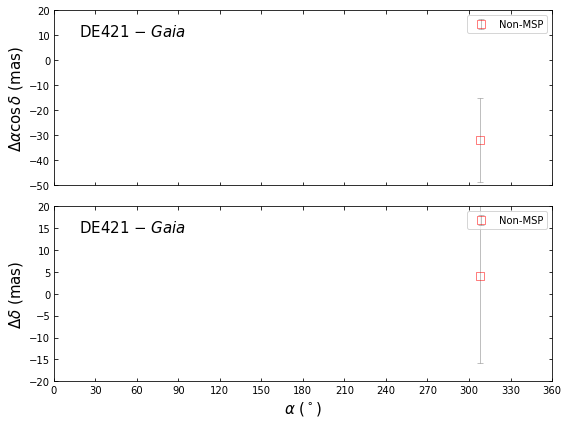

In [38]:
pos_oft_vs_coord(edr3_timing421, [-50, 20, -20, 20],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 add_text=[0.05, 0.85, "DE421 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

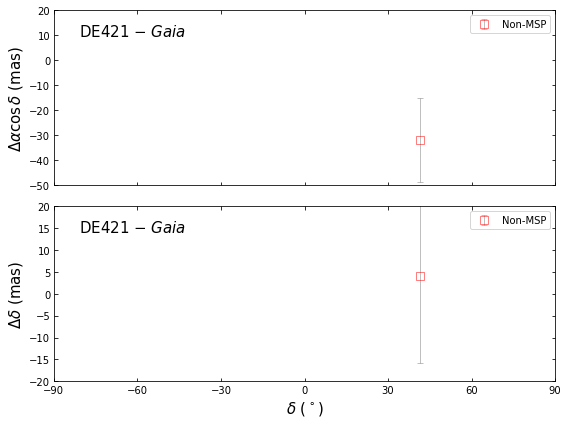

In [39]:
pos_oft_vs_coord(edr3_timing421, [-50, 20, -20, 20],
                 edr3_timing421["dra"],
                 edr3_timing421["ddec"],
                 add_text=[0.05, 0.85, "DE421 $-$ $Gaia$"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

## 1.4 DE430 vs Gaia EDR3

In [40]:
mask = edr3_timing["eph"] == "DE430"
edr3_timing430 = edr3_timing[mask]

nb_psr_430 = len(edr3_timing430.group_by("psr_name").groups)
nb_obs_430 = len(edr3_timing430)

count_psr_nb(edr3_timing430)
# edr3_timing430

There are 3 pulsars with 4 measurements.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


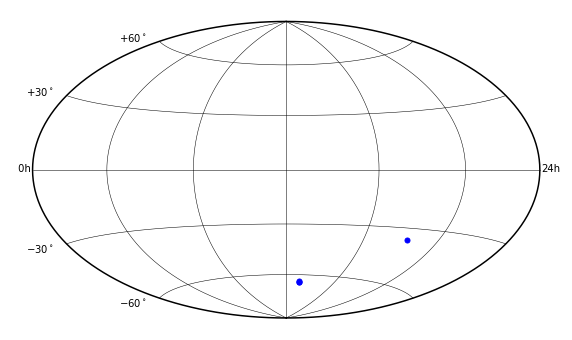

In [41]:
sou_dist_plot(edr3_timing430["ra_g"], edr3_timing430["dec_g"],)

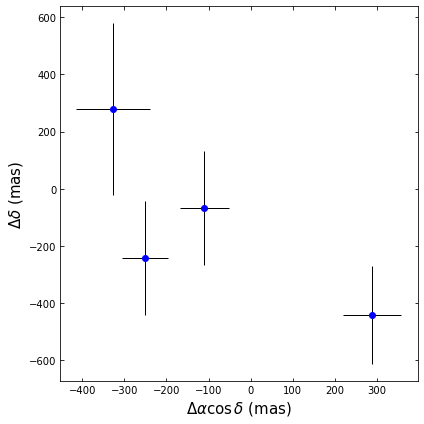

In [42]:
simple_plot(edr3_timing430)

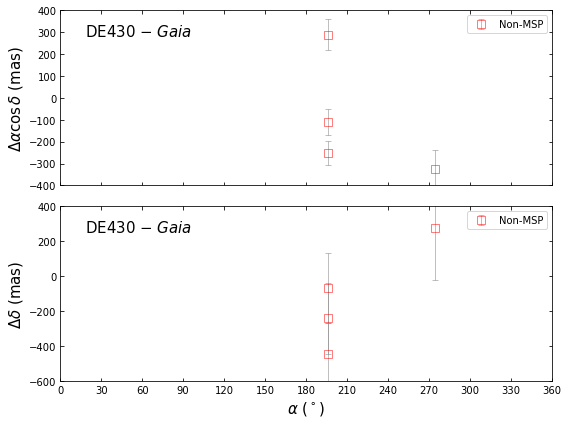

In [43]:
pos_oft_vs_coord(edr3_timing430, [-400, 400, -600, 400],
                 edr3_timing430["dra"],
                 edr3_timing430["ddec"],
                 add_text=[0.05, 0.85, "DE430 $-$ $Gaia$"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

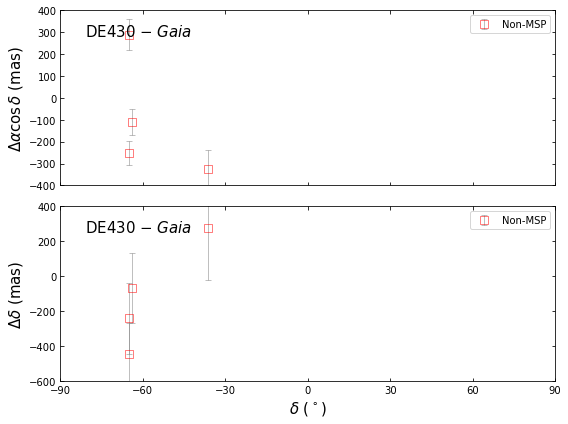

In [44]:
pos_oft_vs_coord(edr3_timing430, [-400, 400, -600, 400],
                 edr3_timing430["dra"],
                 edr3_timing430["ddec"],
                 add_text=[0.05, 0.85, "DE430 $-$ $Gaia$"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

In [45]:
# pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
#     edr3_timing430)

rot430, iqr430, dra_430, ddec_430, a_chi2_430, p_chi2_430 = simple_rot_fit_4_table(
    edr3_timing430, ref="g")

[msg] There are 4 timing solutions for 3 pulsars
[msg] Before removing outliers, the reduced chi-squared is 9.35.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  4  3      9.4     10.1    -147.58    -328.89    -647.07     185.60     332.95     404.03


## 1.5 DE436 vs Gaia EDR3

In [46]:
mask = edr3_timing["eph"] == "DE436"
edr3_timing436 = edr3_timing[mask]

# edr3_timing436
count_psr_nb(edr3_timing436)

There are 0 pulsars with 0 measurements.


There is no pulsar in the DE436 frame.

In [47]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"])

print(tbl)

Positional formal uncertainty for timing and Gaia positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200   164.56    600.00    704.51     0.24      0.25      0.35
DE405   215.02    650.00    684.85     0.05      0.04      0.06
DE421   200.46   8510.00   8515.25     0.28      0.27      0.39
DE430    63.87    200.00    207.73     0.03      0.03      0.04
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [49]:
mydata = [[nb_psr_200, nb_obs_200,
           rot200[0], iqr200[0], rot200[1], iqr200[1], rot200[2], iqr200[2],
          a_chi2_200, p_chi2_200],
          # [nb_psr_405, nb_obs_405,
          #  rot405_a[0], iqr405_a[0], rot405_a[1], iqr405_a[1], rot405_a[2], iqr405_a[2],
          #  a_chi2_405, p_chi2_405],
          #           [nb_psr_421, nb_obs_421,
          #            rot421[0], iqr421[0], rot421[1], iqr421[1], rot421[2], iqr421[2],
          #            a_chi2_421, p_chi2_421],
          [nb_psr_430, nb_obs_430,
           rot430[0], iqr430[0], rot430[1], iqr430[1], rot430[2], iqr430[2],
           a_chi2_430, p_chi2_430]]

myheaders = ["Nb.PSR", "Nb.Obs", "R1", "R1_err", "R2", "R2_err", "R3", "R3_err",
             "ApreFitChi2", "PostFitChi2"]
# mystubs = ["DE200", "DE405", "DE421", "DE430"]
mystubs = ["DE200", "DE430"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame for Non-MSP (mas)",
    data_fmts=["%d", "%d", "%6.1f", "%6.1f", "%6.1f", "%6.1f", "%6.1f", "%6.1f",
               "%6.2f", "%6.2f"])

print(tbl)

              Orientation of DE frame wrt. Gaia frame for Non-MSP (mas)              
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200      7      7 -158.4   62.5 -402.3   28.8 -292.2  127.7        5.52        0.82
DE430      3      4 -147.6  185.6 -328.9  333.0 -647.1  404.0        9.35       10.10
-------------------------------------------------------------------------------------
